# Content:
1. Recurrent Neural Networks for Language Modeling
2. LSTMs and Named Entity Recognition
3. Siamese Networks

# RNN for LM

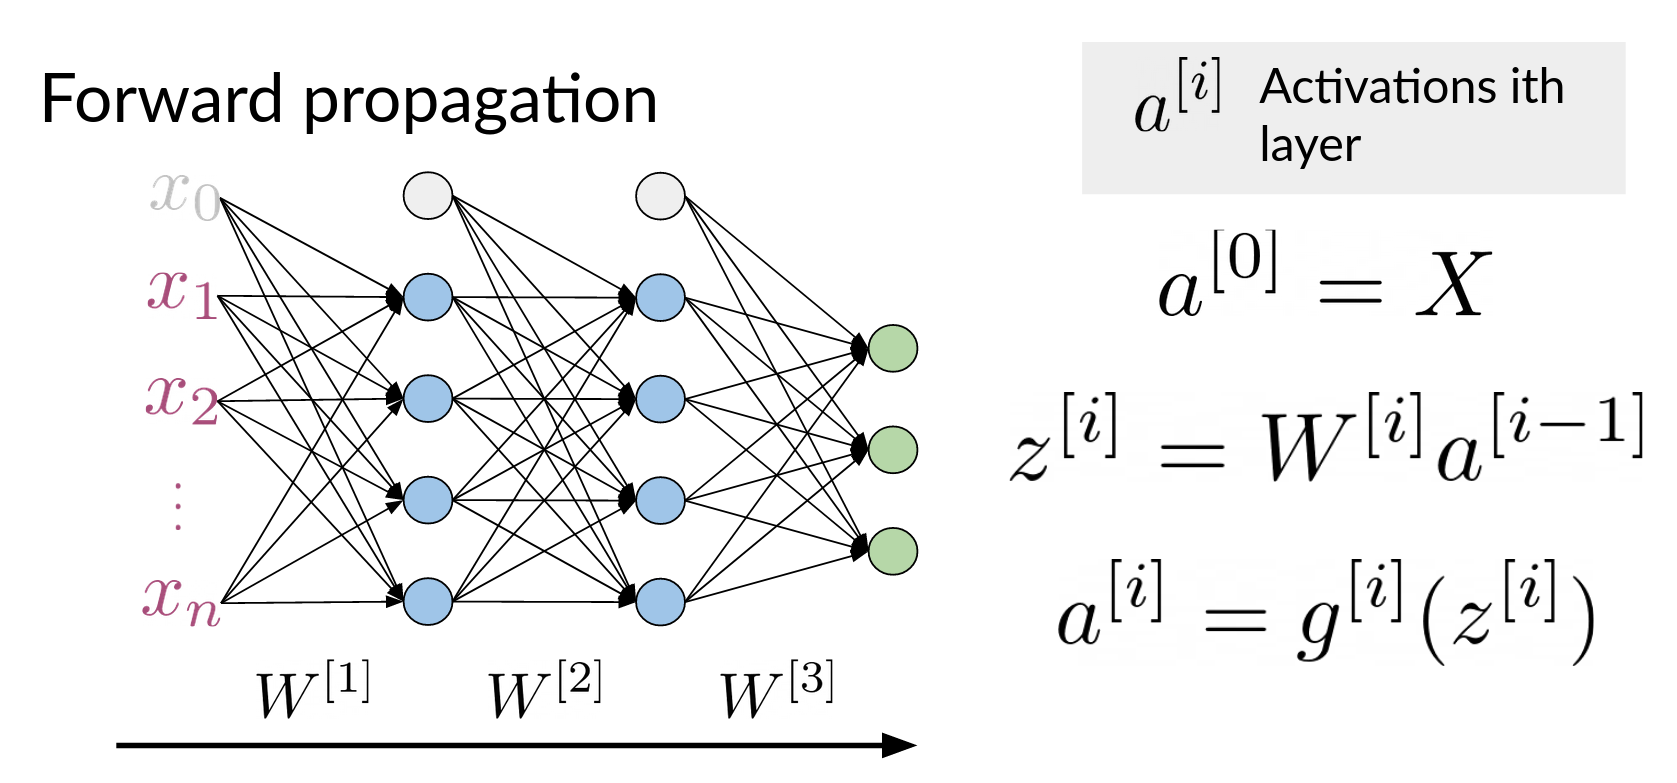

### Main layers that are very commonly used in most neural networks:
* a Dense layer which allows you to go from one layer to another inside the network
* a ReLu, layer that keeps your network stable
* an Embedding layer
* a Pooling (Mean) layer

The Dense layer is the computation of the inner product between a set of trainable weights (weight matrix) and an input vector.  The visualization of the dense layer can be seen in the image below. 

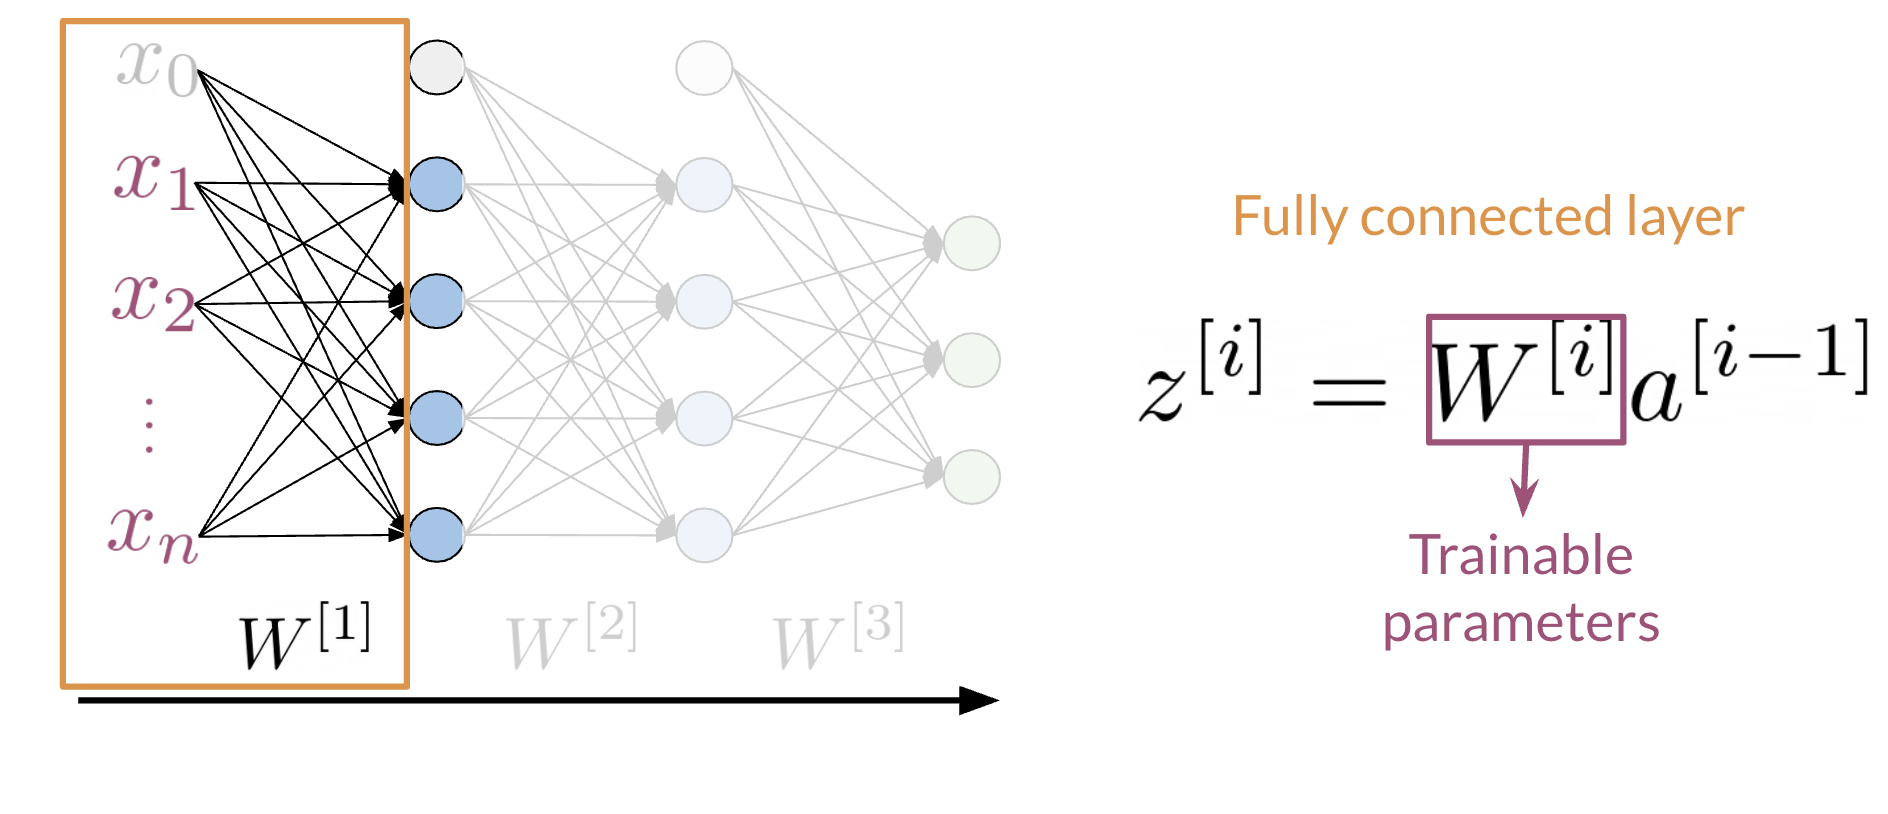

The orange box in the image above shows the dense layer. An activation layer is the set of blue nodes shown with the orange box in the image below. Concretely one of the most commonly used activation layers is the rectified linear unit (ReLU). ReLU(x) is defined as max(0,x) for any input x. 

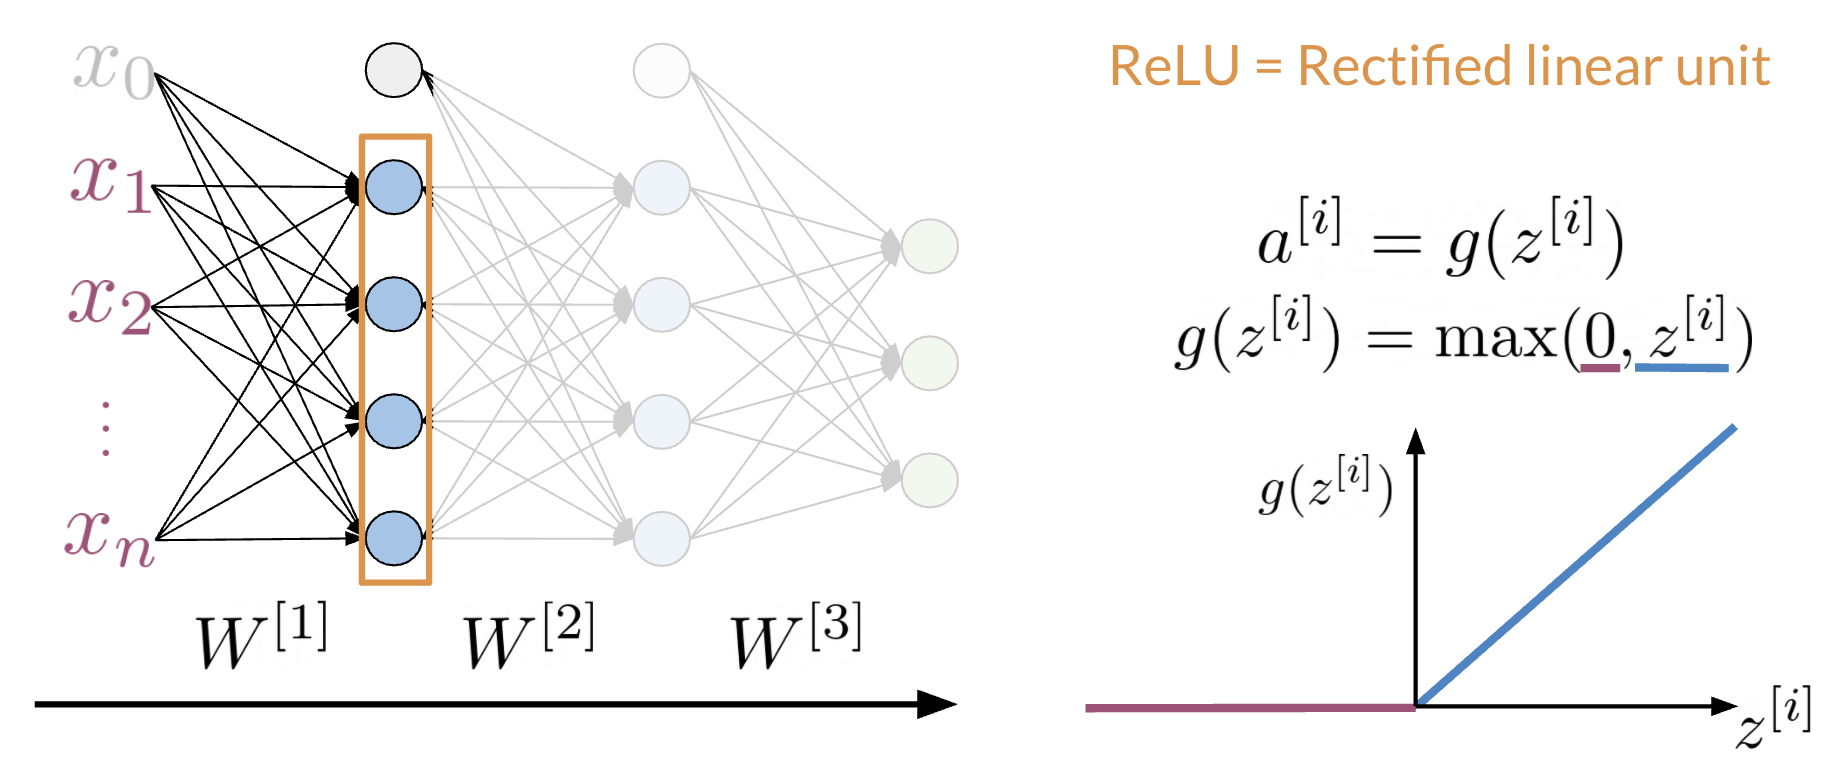

Using an embedding layer you can learn word embeddings for each word in your vocabulary.

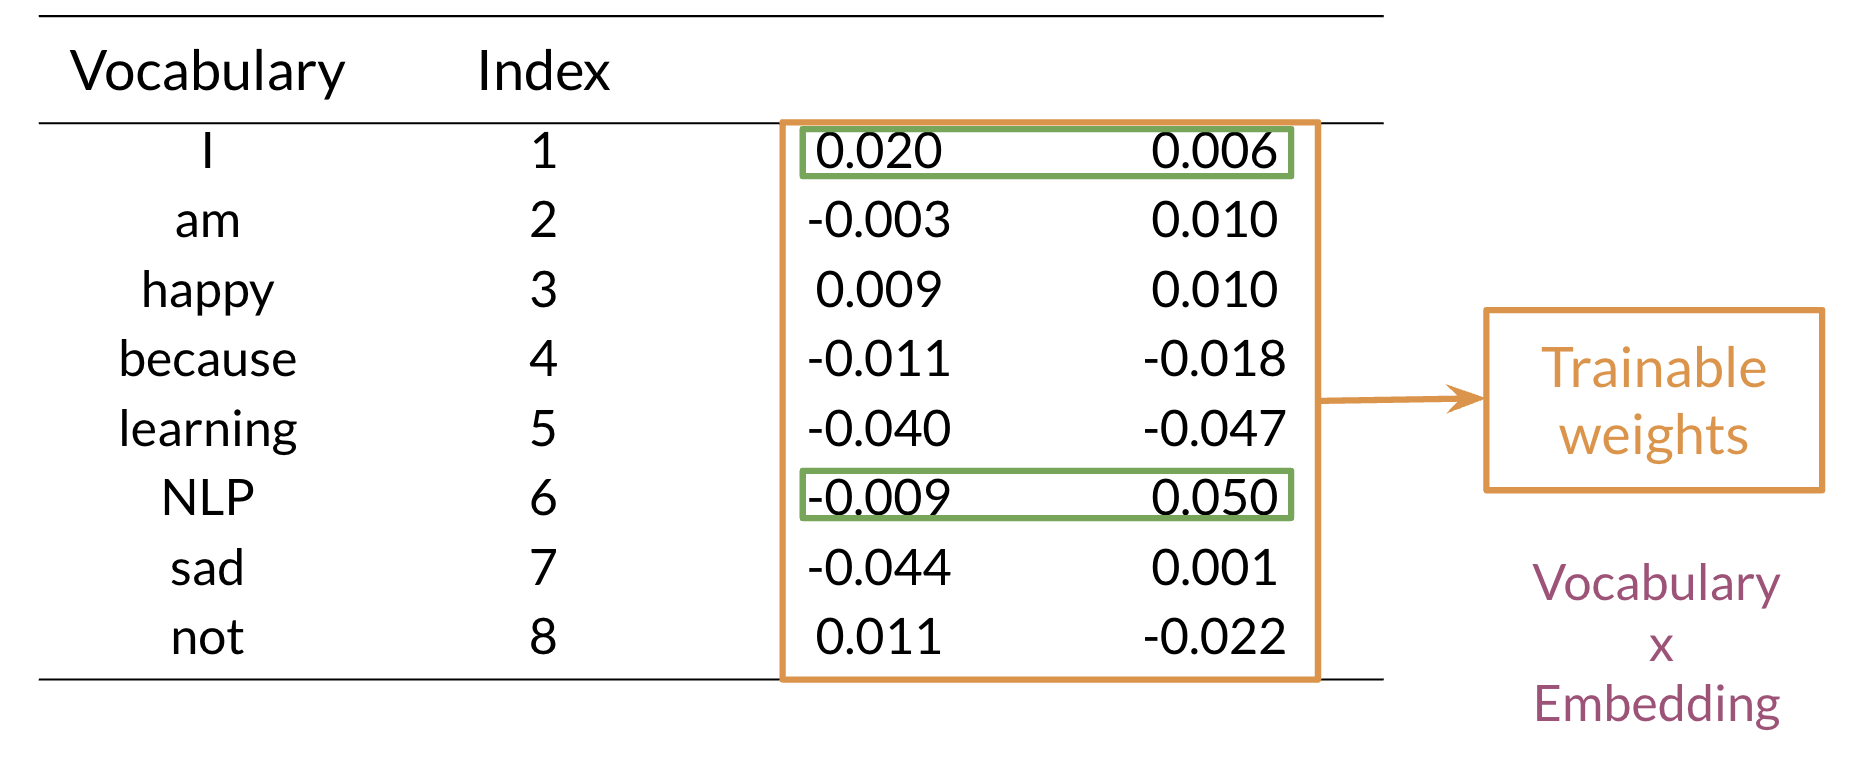

The mean layer allows you to take the average of the embeddings. This layer does not have any trainable parameters.  

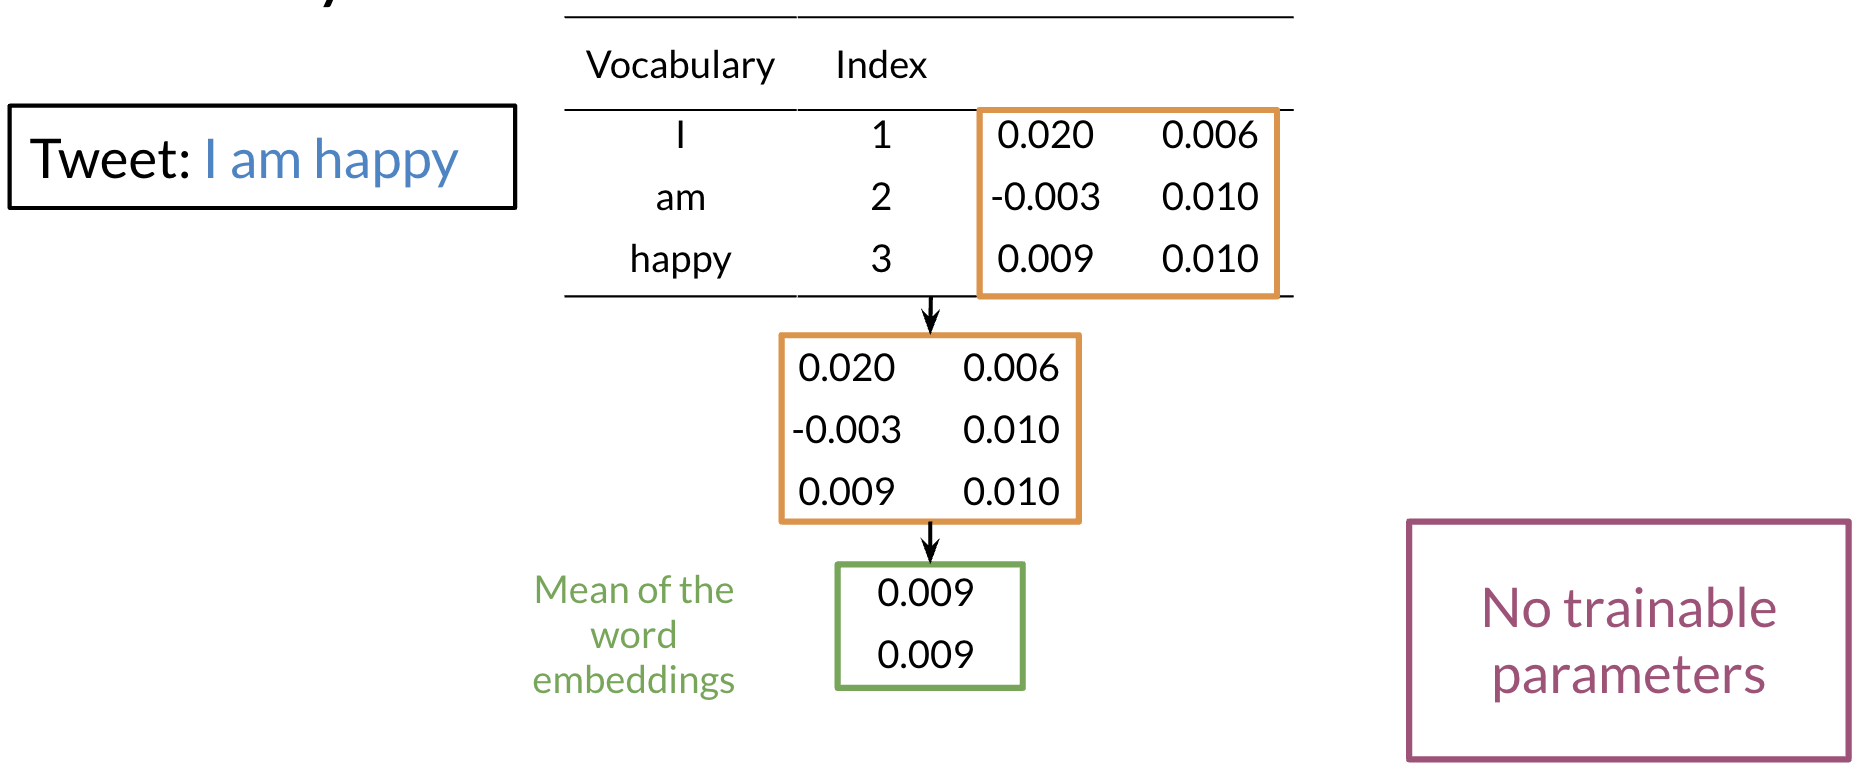

# Sentiment with Deep Neural Networks (implementation)

In [14]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from utils import load_tweets, process_tweet

In [15]:
# Load positive and negative tweets
all_positive_tweets, all_negative_tweets = load_tweets()

# View the total number of positive and negative tweets.
print(f"The number of positive tweets: {len(all_positive_tweets)}")
print(f"The number of negative tweets: {len(all_negative_tweets)}")

The number of positive tweets: 5000
The number of negative tweets: 5000


In [16]:
# Change the tweet number to any number between 0 and 4999 to see a different pair of tweets.
tweet_number = 4
print('Positive tweet example:')
print(all_positive_tweets[tweet_number])
print('\nNegative tweet example:')
print(all_negative_tweets[tweet_number])

Positive tweet example:
yeaaaah yippppy!!!  my accnt verified rqst has succeed got a blue tick mark on my fb profile :) in 15 days

Negative tweet example:
Dang starting next week I have "work" :(


The processing includes:

tokenizing the sentence (splitting to words)
removing stock market tickers like $GE
removing old style retweet text "RT"
removing hyperlinks
removing hashtags
lowercasing
removing stopwords and punctuation
stemming

In [17]:
# Process all the tweets: tokenize the string, remove tickers, handles, punctuation and stopwords, stem the words
all_positive_tweets_processed = [process_tweet(tweet) for tweet in all_positive_tweets]
all_negative_tweets_processed = [process_tweet(tweet) for tweet in all_negative_tweets]

In [19]:
# Change the tweet number to any number between 0 and 4999 to see a different pair of tweets.
tweet_number = 44
print('Positive processed tweet example:')
print(all_positive_tweets_processed[tweet_number])
print('\nNegative processed tweet example:')
print(all_negative_tweets_processed[tweet_number])

Positive processed tweet example:
['would', 'love', 'see', 'dear', 'jordan', ':)', 'wait', ':)']

Negative processed tweet example:
['pret', ':(', 'wkwkw', 'verfied', 'active', 'forget', 'follow', 'member', 'thanks', 'join', 'goodbye']


In [20]:
# Split positive set into validation and training
val_pos = all_positive_tweets_processed[4000:]
train_pos = all_positive_tweets_processed[:4000]
# Split negative set into validation and training
val_neg = all_negative_tweets_processed[4000:]
train_neg = all_negative_tweets_processed[:4000]

train_x = train_pos + train_neg 
val_x  = val_pos + val_neg

# Set the labels for the training and validation set (1 for positive, 0 for negative)
train_y = [[1] for _ in train_pos] + [[0] for _ in train_neg]
val_y  = [[1] for _ in val_pos] + [[0] for _ in val_neg]

print(f"There are {len(train_x)} sentences for training.")
print(f"There are {len(train_y)} labels for training.\n")
print(f"There are {len(val_x)} sentences for validation.")
print(f"There are {len(val_y)} labels for validation.")

There are 8000 sentences for training.
There are 8000 labels for training.

There are 2000 sentences for validation.
There are 2000 labels for validation.


In [21]:
# FUNCTION: build_vocabulary
def build_vocabulary(corpus):
    '''Function that builds a vocabulary from the given corpus
    Input: 
        - corpus (list): the corpus
    Output:
        - vocab (dict): Dictionary of all the words in the corpus.
                The keys are the words and the values are integers.
    '''

    # The vocabulary includes special tokens like padding token and token for unknown words
    # Keys are words and values are distinct integers (increasing by one from 0)
    vocab = {'': 0, '[UNK]': 1} 
   
    # For each tweet in the training set
    for tweet in corpus:
        # For each word in the tweet
        for word in tweet:
            # If the word is not in vocabulary yet, add it to vocabulary
            if word not in vocab:
                vocab[word] = max(list(vocab.values())) + 1
        
    return vocab


vocab = build_vocabulary(train_x)
num_words = len(vocab)

print(f"Vocabulary contains {num_words} words\n")
print(vocab)

Vocabulary contains 9535 words

{'': 0, '[UNK]': 1, 'followfriday': 2, 'top': 3, 'engage': 4, 'member': 5, 'community': 6, 'week': 7, ':)': 8, 'hey': 9, 'james': 10, 'odd': 11, ':/': 12, 'please': 13, 'call': 14, 'contact': 15, 'centre': 16, '02392441234': 17, 'able': 18, 'assist': 19, 'many': 20, 'thanks': 21, 'listen': 22, 'last': 23, 'night': 24, 'bleed': 25, 'amazing': 26, 'track': 27, 'scotland': 28, 'congrats': 29, 'yeaaah': 30, 'yipppy': 31, 'accnt': 32, 'verify': 33, 'rqst': 34, 'succeed': 35, 'get': 36, 'blue': 37, 'tick': 38, 'mark': 39, 'fb': 40, 'profile': 41, '15': 42, 'day': 43, 'one': 44, 'irresistible': 45, 'flipkartfashionfriday': 46, 'like': 47, 'keep': 48, 'lovely': 49, 'customer': 50, 'wait': 51, 'long': 52, 'hope': 53, 'enjoy': 54, 'happy': 55, 'friday': 56, 'lwwf': 57, 'second': 58, 'thought': 59, '’': 60, 'enough': 61, 'time': 62, 'dd': 63, 'new': 64, 'short': 65, 'enter': 66, 'system': 67, 'sheep': 68, 'must': 69, 'buy': 70, 'jgh': 71, 'go': 72, 'bayan': 73, ':D

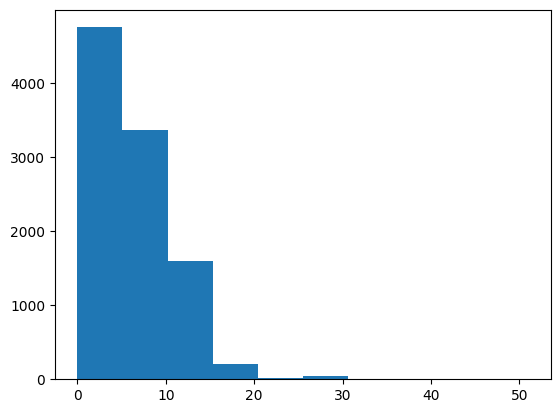

In [22]:
# Tweet lengths
plt.hist([len(t) for t in train_x + val_x]);

In [23]:
# FUNCTION: max_length
def max_length(training_x, validation_x):
    """Computes the length of the longest tweet in the training and validation sets.

    Args:
        training_x (list): The tweets in the training set.
        validation_x (list): The tweets in the validation set.

    Returns:
        int: Length of the longest tweet.
    """

    max_len = max([len(x) for x in training_x+validation_x])
    
    return max_len

max_len = max_length(train_x, val_x)
print(f'The length of the longest tweet is {max_len} tokens.')

The length of the longest tweet is 51 tokens.


In [24]:
# FUNCTION: padded_sequence
def padded_sequence(tweet, vocab_dict, max_len, unk_token='[UNK]'):
    """transform sequences of words into padded sequences of numbers

    Args:
        tweet (list): A single tweet encoded as a list of strings.
        vocab_dict (dict): Vocabulary.
        max_len (int): Length of the longest tweet.
        unk_token (str, optional): Unknown token. Defaults to '[UNK]'.

    Returns:
        list: Padded tweet encoded as a list of int.
    """
    # Find the ID of the UNK token, to use it when you encounter a new word
    unk_ID = vocab_dict[unk_token] 
    
    # First convert the words to integers by looking up the vocab_dict
    word2int = [vocab_dict[x] if x in vocab_dict else unk_ID for x in tweet ]

    # Then pad the tensor with zeroes up to the length max_len
    padded_tensor = word2int + [0]*(max_len - len(word2int))

    return padded_tensor

In [25]:
train_x_padded = [padded_sequence(x, vocab, max_len) for x in train_x]
val_x_padded = [padded_sequence(x, vocab, max_len) for x in val_x]

In [26]:
# FUNCTION: relu
def relu(x):
    '''Relu activation function implementation
    Input: 
        - x (numpy array)
    Output:
        - activation (numpy array): input with negative values set to zero
    '''

    activation = np.maximum(x, 0)

    return activation

In [27]:
# FUNCTION: sigmoid
def sigmoid(x):
    '''Sigmoid activation function implementation
    Input: 
        - x (numpy array)
    Output:
        - activation (numpy array)
    '''

    activation = 1 / (1 + np.exp(-x))

    return activation    

In [28]:
# CLASS: Dense
class Dense():
    """
    A dense (fully-connected) layer.
    """

    # Please implement '__init__'
    def __init__(self, n_units, input_shape, activation, stdev=0.1, random_seed=42):
        
        # Set the number of units in this layer
        self.n_units = n_units
        # Set the random key for initializing weights
        self.random_generator = np.random.default_rng(seed=random_seed)
        self.activation = activation
        
        # Generate the weight matrix from a normal distribution and standard deviation of 'stdev'
        # Set the size of the matrix w
        w = self.random_generator.normal(loc=0, scale=stdev, size=(input_shape[1], self.n_units))
        
        self.weights = w
        

    def __call__(self, x):
        return self.forward(x)
    
    
    # Please implement 'forward()'
    def forward(self, x):
        
        # Matrix multiply x and the weight matrix
        dense = np.dot(x, self.weights)
        # Apply the activation function
        dense = self.activation(dense)
        
        return dense

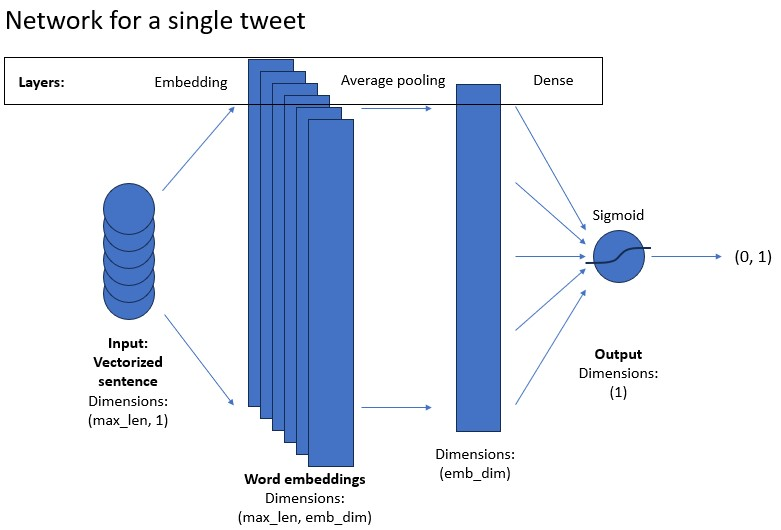

In [29]:
# FUNCTION: create_model
def create_model(num_words, embedding_dim, max_len):
    """
    Creates a text classifier model
    
    Args:
        num_words (int): size of the vocabulary for the Embedding layer input
        embedding_dim (int): dimensionality of the Embedding layer output
        max_len (int): length of the input sequences
    
    Returns:
        model (tf.keras Model): the text classifier model
    """
    
    tf.random.set_seed(123)
       
    model = tf.keras.Sequential([ 
        tf.keras.layers.Embedding(num_words, embedding_dim, input_length=max_len),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ]) 
    
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

In [30]:
# Create the model
model = create_model(num_words=num_words, embedding_dim=16, max_len=max_len)

print('The model is created!\n')



The model is created!



In [31]:
# Prepare the data
train_x_prepared = np.array(train_x_padded)
val_x_prepared = np.array(val_x_padded)

train_y_prepared = np.array(train_y)
val_y_prepared = np.array(val_y)

print('The data is prepared for training!\n')

# Fit the model
print('Training:')
history = model.fit(train_x_prepared, train_y_prepared, epochs=20, validation_data=(val_x_prepared, val_y_prepared))

The data is prepared for training!

Training:
Epoch 1/20


250/250 [==============================] - 2s 4ms/step - loss: 0.6851 - accuracy: 0.6345 - val_loss: 0.6720 - val_accuracy: 0.9665
Epoch 2/20
250/250 [==============================] - 1s 3ms/step - loss: 0.6409 - accuracy: 0.9314 - val_loss: 0.6080 - val_accuracy: 0.9735
Epoch 3/20
250/250 [==============================] - 1s 3ms/step - loss: 0.5523 - accuracy: 0.9868 - val_loss: 0.5107 - val_accuracy: 0.9900
Epoch 4/20
250/250 [==============================] - 1s 3ms/step - loss: 0.4447 - accuracy: 0.9898 - val_loss: 0.4081 - val_accuracy: 0.9925
Epoch 5/20
250/250 [==============================] - 1s 3ms/step - loss: 0.3451 - accuracy: 0.9941 - val_loss: 0.3192 - val_accuracy: 0.9920
Epoch 6/20
250/250 [==============================] - 1s 4ms/step - loss: 0.2641 - accuracy: 0.9945 - val_loss: 0.2497 - val_accuracy: 0.9955
Epoch 7/20
250/250 [==============================] - 1s 3ms/step - loss: 0.2027 - accuracy: 0.9952 

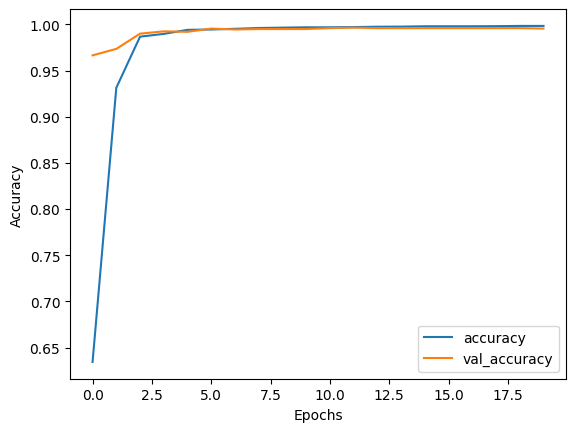

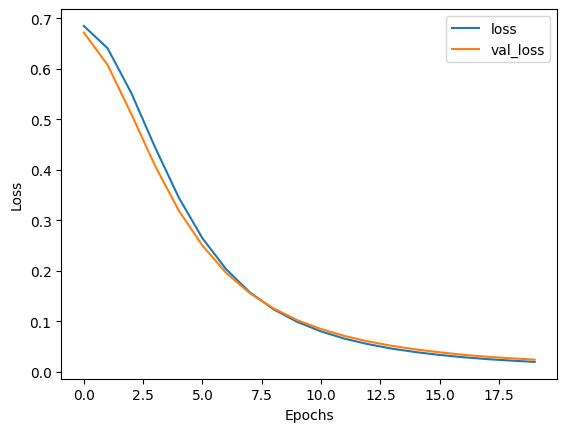

In [32]:
def plot_metrics(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric.title())
    plt.legend([metric, f'val_{metric}'])
    plt.show()
    
plot_metrics(history, "accuracy")
plot_metrics(history, "loss")

In [33]:
# Prepare an example with 10 positive and 10 negative tweets.
example_for_prediction = np.append(val_x_prepared[0:10], val_x_prepared[-10:], axis=0)

# Make a prediction on the tweets.
model.predict(example_for_prediction)

1/1 [==============================] - 0s 128ms/step


array([[0.90281415],
       [0.99428886],
       [0.9969695 ],
       [0.95045716],
       [0.99763983],
       [0.9959578 ],
       [0.99202025],
       [0.9796631 ],
       [0.9984699 ],
       [0.99830866],
       [0.01090815],
       [0.04234564],
       [0.01300239],
       [0.01709264],
       [0.01812353],
       [0.00650269],
       [0.01584858],
       [0.0083886 ],
       [0.02376341],
       [0.03456283]], dtype=float32)

In [34]:
def get_prediction_from_tweet(tweet, model, vocab, max_len):
    tweet = process_tweet(tweet)
    tweet = padded_sequence(tweet, vocab, max_len)
    tweet = np.array([tweet])

    prediction = model.predict(tweet, verbose=False)
    
    return prediction[0][0]

In [41]:
unseen_tweet = '@mak_kry NLP make a possitive effect on inhabitants and kids).'

prediction_unseen = get_prediction_from_tweet(unseen_tweet, model, vocab, max_len)
print(f"Model prediction on unseen tweet: {prediction_unseen}")

Model prediction on unseen tweet: 0.5101087689399719


In [36]:
# Get the embedding layer
embeddings_layer = model.layers[0]

# Get the weights of the embedding layer
embeddings = embeddings_layer.get_weights()[0]

# PCA with two dimensions
pca = PCA(n_components=2)

# Dimensionality reduction of the word embeddings
embeddings_2D = pca.fit_transform(embeddings)

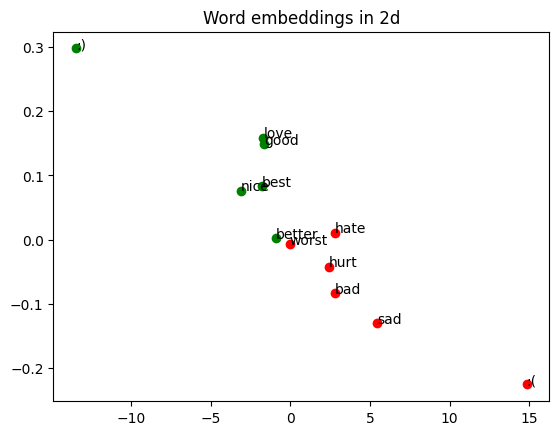

In [38]:
#Selection of negative and positive words
neg_words = ['bad', 'hurt', 'sad', 'hate', 'worst', ':(']
pos_words = ['best', 'good', 'nice', 'love', 'better', ':)']

#Index of each selected word
neg_n = [vocab[w] for w in neg_words]
pos_n = [vocab[w] for w in pos_words]

plt.figure()

#Scatter plot for negative words
plt.scatter(embeddings_2D[neg_n][:,0], embeddings_2D[neg_n][:,1], color = 'r')
for i, txt in enumerate(neg_words): 
    plt.annotate(txt, (embeddings_2D[neg_n][i,0], embeddings_2D[neg_n][i,1]))

#Scatter plot for positive words
plt.scatter(embeddings_2D[pos_n][:,0], embeddings_2D[pos_n][:,1], color = 'g')
for i, txt in enumerate(pos_words): 
    plt.annotate(txt,(embeddings_2D[pos_n][i,0], embeddings_2D[pos_n][i,1]))

plt.title('Word embeddings in 2d')

plt.show()

In [ ]:
# TBD